<a href="https://colab.research.google.com/github/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/Deep_Learning_for_Camera_Traps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 - AI for Wildlife Images

# What we will learn

In this weeks practical we will explore computer vision applications in ecology such as automated animal detection and species classfication from camera traps. Among other stuff we will:

1. Manually annotate animals in camera trap data
2. Apply an automated animal detector on a set of images to acquire labels and compare with manual labeling
3. Analyse automated animal detections
4. Train a neural network for species classification in a camera trap dataset
5. Thorough evaluation of the trained model and analysis of its predictions
6. Experiment with various parameters in the training process of neural networks


# Intro

## Computer Vision

**What is Computer Vision?**

Development of automated systems that can extract useful information from images or sequences of images 

**What do computers see?** <br>
* Images are  2-Dimensional numerical matrices representing the pixel intensity. 
* Colored images become 3-D (RGB). 
* Videos are sequences of such images.


<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/pixels_and_matrices.png?raw=1" alt="drawing" width="400"/>

Most of the computer vision tasks nowadays are tackled with deep neural networks.

**Examples**

* Image Classification: Classifying chest X-Rays of patients as healthy or pneumonia.
* Object Detection: Detecting car signs in traffic cameras for penalty charges.
* Semantic Segmentation: Map pixels of land into water, grassland, roads

<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/cv_tasks.png?raw=1" alt="drawing" width="800"/>

In this lab, we are going to tackle two tasks of ecological interest using Computer Vision, specifically:
* **Object Detection:** Detecting animals in camera trap photos
* **Image Classification:** Classifying species in camera trap data.

We will try to solve the above tasks using Deep Learning, either by exploiting existing models or training our own. <br><br>

**Convolutional Neural Networks (CNNs)** is a neural network type commonly used for computer vision tasks. Their basic component, the convolutional layers are acting like **filters** and training such networks essentially translates to learning the best parameters for these filters. The **key properties of CNNs** that make the successfull on visual data are **locality**, i.e. the ability to perceive jointly neighborhoods of pixels instead of individual pixels and **translational invariance** i.e. understand the existence of an object within an image independntly of where it appears within it.

A typical CNN architecture <br><img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/cnn.png?raw=1" alt="drawing" width="600"/>

The underlying architectures of the models we are going to try out today are based on CNNs
<br><br>

But first let's take a look on what camera trap sensors look like and how this type of data is collected.

## Data Collection

**Camera traps** are static cameras set up in the wild to monitor animal populations. Typically, a shot from a camera trap is triggered by motion taking place in the camera's field of view.

Each camera trap site can represent variables that ecologists want to include in their analysis. For example, the location of a camera can correspond to different gradients of human pressure. Thus, observing the biodiversity across different locations and hence different gradients of anthropogenic pressure can help us quantify the impact and potentially inform future decision making.

<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/ct.png?raw=1" alt="drawing" width="200"/>

Below you see consecutive frames captured by a camera trap in Kenya. It shows a hyena entering the scene and checking out a buffalo!

<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/hyena.gif?raw=1" alt="drawing" width="500"/>

(image frames from a camera trap set up in Kenya for the [Biome Health Project](https://www.biomehealthproject.com/))

## The utility of GPUs for Computer Vision
* As you know by know, more data can train better algorithms
* Graphics Processing Units (GPUs) enable parallelization in the way we process data and thus allow for inclusion of more without compromising the time needed to train a model with them 
* Especially useful for image processing



---



# Setup Steps
The following steps are required to set the notebook for the tasks of this lab. Follow the instructions but do not pay attention to the code and potential output messages as they are irrelevant for main content of the lab

## A) Before starting make sure you change the hardware for this notebook to GPU.
* To do this go to *'Runtime'* then *'Change runtime type'* and select GPU as the preferred Hardware accelerator.

## B) Mount your Google Drive, link to the data we will use today and unzip

* Mount your Google drive to this Colab by running the following command

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* The camera trap data and some functions we are going to use for the lab are stored in the following public GDrive folder:<br>https://drive.google.com/drive/folders/14pRqZAfAq6o-jPU_Zllt20I9Rykwfyxt?usp=sharing
* Open the above link and select the *'Add shortcut to Drive'* option as shown in the image below and then select *'MyDrive'*. This should now be available in your 'drive' folder in the 'Files' tab of Colab and ready to use for species classification.



<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/add_data_shortcut_to_drive.png?raw=1" alt="drawing" width="400"/>

* Finally, unzip the data in our working directory

In [ ]:
%%capture
!unzip drive/MyDrive/BIOS0032_AI4Environment_Lab3Data_Compressed/BIOS0032_AI4Environment_Lab3Data.zip -d /content

## C) Install Dependencies

Let's install some dependencies for today's lab.

* First, let's install some tools for image annotation

In [ ]:
%%capture
import os
import pathlib
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
os.chdir('models/research')

In [ ]:
%%capture
# Install the Object Detection API
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

In [ ]:
os.chdir('../..')

* Next, we install [PyTorch](https://pytorch.org/), the deep learning library we are going to use for the deep learning experiments. In addition, we are going to setup [MegaDetector](https://github.com/microsoft/CameraTraps/blob/main/megadetector.md), the animal detection framework developed by Microsoft AI for Earth.

<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/3_AI_for_Wildlife_Images/images/pt_and_ai4earth.png?raw=1" alt="drawing" width="400"/><br><br>

* Installing PyTorch (might take around 2 minutes)

In [ ]:
%%capture
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

* Download most recent MegaDetector model and install some of its dependencies.

In [ ]:
%%capture
!wget -O /content/md_v5a.0.0.pt https://github.com/microsoft/CameraTraps/releases/download/v5.0/md_v5a.0.0.pt
!pip install humanfriendly jsonpickle

* Clone the Github repositories needed to run MegaDetector on this machine. These include the latest CameraTraps and essential utilities by Microsoft AI for Earth along with the YOLOv5 repository (YOLO is an established family of object detectors in vision)

In [ ]:
%%capture
!git clone https://github.com/microsoft/CameraTraps 
!git clone https://github.com/microsoft/ai4eutils
!git clone https://github.com/ultralytics/yolov5/
!cd yolov5 && git checkout c23a441c9df7ca9b1f275e8c8719c949269160d1

* Include the git repositories downloaded above to the python path, so that they become easily accessible through code

In [ ]:
import sys
os.environ['PYTHONPATH'] += ":/content/ai4eutils"
os.environ['PYTHONPATH'] += ":/content/CameraTraps"
os.environ['PYTHONPATH'] += ":/content/yolov5"



---



# **Part 1: Detecting Animals in Camera Trap Data**

* After camera traps for a survey are set up, photos are captured automatically which means that **huge amounts of data can be accumulated** after some time. Interesting insights can be hiding within large image collections and even though having access to these collection sounds great, it also means that ecologists will need to spend a lot of time to view them, identify and report their underlying content.
* As a matter of fact, **many of the images can be empty** as sensors can be triggered by irrelevant movements in the environment. In addition, it is possible to witness presence of humans or vehicles in the scene i.e. categories that are not necessarily interesting for biodiversity monitoring. 
* On that end, computer vision approaches such as [MegaDetector](https://github.com/microsoft/CameraTraps/blob/main/megadetector.md) can be exploited to **accelerate the labeling process** and optimize for the time ecologists spend on the consevation efforts. 



But first, let's try to understand how we would tackle the image labeling problem manually

## Image Labeling

The annotation of images can be intended for a couple of different scenarios:
* Use the acquired information directly for ecological analysis
* Use the images along with the associated labels obtained to train a machine learning model in a *supervised learning* setting

Given the large amounts of camera trap data produced, ecologistics traditionally take a subset of the images, annotate and directly use the obtained information to reason about the underlying ecosystem 

### Labeling Images for Ecological Analysis

* Labeling is a time-consuming process
* Usually compromises are needed, e.g. annotating a subsample of the data
* Plus, the more time a human spends labeling the more likely it is to start making mistakes!

Now Let's try to label 10 images on our own to see how the process is

In [ ]:
# path for detection data
detection_data_path = '/content/BIOS0032_AI4Environment_Lab3Data/detection_data/'

In [ ]:
# import libraries we'll use for the detection task
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import time
from object_detection.utils import colab_utils
import pandas as pd
%matplotlib inline

# import custom_functions
os.chdir(detection_data_path)
from utils import load_image_into_numpy_array, transform_md_output_to_df
os.chdir('/content')

Let's load the images to annotate

In [ ]:
# total number of images to annoate
total_images = 10

# define path where the images are and get a list of all the images inside it
image_directory = os.path.join(detection_data_path,'images/') #
list_of_images = os.listdir(image_directory) 
selected_list_of_images = ['2018_NB01_001794.JPG','2018_NB40_002921.JPG','2018_MT22_020230.JPG','2018_OMC11_009862.JPG','2018_NB26_025049.JPG','2018_MN33_009632.JPG', '2018_NB26_000679.JPG','2018_MT27_005639.JPG','2018_NB05_002216.JPG','2018_NB47_006890.JPG']

# create a list with the numpy arrays that correspond to each of the images to annotate
list_of_image_arrays = []
for i,image in enumerate(selected_list_of_images):
  image_path = os.path.join(image_directory,image)
  image_array = load_image_into_numpy_array(image_path,output_image_dimensions=(1000,600))
  list_of_image_arrays.append(image_array)

### **Exercise** 🐘
---
<br>

* The **task is to annotate a set of 10 images**, putting a box around anything you believe is an animal. If an image has more than one animal, you should do this for all of them
* Try to place the box directly around the animal, i.e. not including anything else 
* Some of these images can be empty, so if you can not see any animal, go to next image. 
* Start the process by running the next 2 cells. When you are done click submit and run the following cell right after to measure your time.


In [ ]:
annotation_starts = time.time()

In [ ]:
# list to store object detection annotations
tagged_image_boxes = []
# lets start annotatin the list of images generated above
colab_utils.annotate(list_of_image_arrays, box_storage_pointer=tagged_image_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# run this cell straight after your annotation
annotation_ends = time.time()

In [ ]:
# convert time to minutes
minutes = (annotation_ends-annotation_starts)//60
seconds = (annotation_ends-annotation_starts)%60
print('The annotation of the {} images lasted {} minutes and {} seconds'.format(total_images,int(minutes),np.round(seconds,1)))

The annotation of the 10 images lasted 1 minutes and 0.8 seconds


In [ ]:
# lets see how the produced animal annotations look like
print(tagged_image_boxes)

[array([[0.58940104, 0.01      , 0.96606771, 0.339     ],
       [0.48106771, 0.525     , 0.85106771, 0.681     ],
       [0.41773437, 0.447     , 0.97106771, 0.881     ]]), array([[0.34773438, 0.        , 0.73606771, 0.21      ]]), None, None, array([[0.36273437, 0.057     , 0.84106771, 0.569     ],
       [0.10606771, 0.006     , 0.45606771, 0.135     ],
       [0.15273438, 0.338     , 0.56773438, 0.727     ],
       [0.00106771, 0.616     , 0.80440104, 0.988     ]]), array([[0.07273438, 0.155     , 0.26773438, 0.325     ]]), array([[0.01273437, 0.        , 0.76940104, 0.347     ]]), None, array([[0.30773438, 0.226     , 0.44773438, 0.316     ],
       [0.28106771, 0.296     , 0.43273438, 0.402     ],
       [0.24606771, 0.317     , 0.36273437, 0.462     ],
       [0.25106771, 0.444     , 0.36106771, 0.51      ]]), array([[0.22106771, 0.527     , 0.41773437, 0.619     ],
       [0.42440104, 0.738     , 0.58940104, 0.935     ]])]


Each image that contains an animal has one or more boxes that correspond define the position of the 4 edges of the box within the image. The empty images have a None value instead

In [ ]:
# given produced annotation list, we calculate total animals and the number of images with animals
number_of_animal_tags = sum(x.shape[0] for x in tagged_image_boxes if x is not None)
number_images_with_animal_tags = sum(x is not None for x in tagged_image_boxes)
print('In total, you found {} animals across {} images while {} out of the {} images were tagged as empty.'.format(number_of_animal_tags,number_images_with_animal_tags,total_images-number_images_with_animal_tags,total_images))


In total, you found 16 animals across 7 images while 3 out of the 10 images were tagged as empty.


## MegaDetector

* As mentioned above, to detect animals automatically we will utilize [**MegaDetector**](https://github.com/microsoft/CameraTraps/blob/main/megadetector.md), a model developed and trained by Microsoft AI for Earth on lots of annotated images captured in a variety of ecosystems. This model is able to **detect animals, people, and vehicles within camera trap images**. 
* An already trained or else  **pretrained** model is essentially corresponding to a model with parameters learnt when training with a dataset different from the one in our task. Here, we use the model pretrained to detect animals to reason about our images.
* MegaDetector detections comes with a confidence threshold between 0 and 1 where 0 corresponds to a completely certain prediction and 1 to a fully certain one.
* For the particular tasks, images with low animal detection confidence are considered **empty**.
* Note: Depending on our task we might want to relax this threhold, i.e. if we do not want to miss a single animal and we can afford viewing false detections we can lower it

### Run MegaDetector on a set of camera trap images collected in Kenya
These include the 10 images you annotated in the task above

In [ ]:
# define confidence threshold for MegaDetector. Images with detections below this confidence will be considered empty
confidence_threshold='0.2' 
# define path where MegaDetector's detections will be saved
output_file_path ='/content/results/md_detections.json'
# name of pretrained model
pretrained_model='md_v5a.0.0.pt'

In [ ]:
# run megadetector with the defined parameters on the images under the image directory
!python /content/CameraTraps/detection/run_detector_batch.py "$pretrained_model" "$image_directory" "$output_file_path" --threshold "$confidence_threshold" --recursive --output_relative_filenames --quiet

50 image files found in the input directory
PyTorch reports 1 available CUDA devices
GPU available: True
Using PyTorch version 1.10.1+cu113
Fusing layers... 
Model summary: 574 layers, 139990096 parameters, 0 gradients
Sending model to GPU
Loaded model in 6 seconds
Loaded model in 6 seconds
100% 50/50 [00:10<00:00,  4.92it/s]
Finished inference for 50 images in 17.71 seconds
Output file saved at /content/results/md_detections.json
Done!


MegaDetector produced a dictionary with the detection for each image. For the same set of 10 images we calculate again the total animals and the number of images that included at least one

In [ ]:
# given the generated file with megadetector's detection , we calculate total animals and the number of images with animals
with open(output_file_path) as f:
  md_detections = json.load(f)
animals_per_img_MD = []
for md_tagged_img in md_detections['images']:
  if md_tagged_img['file'] in selected_list_of_images:
    animals_per_img_MD.append(len(md_tagged_img['detections']))
number_of_animal_tags_MD = np.sum(animals_per_img_MD) 
number_images_with_animal_tags_MD = np.count_nonzero(animals_per_img_MD)
np.sum(np.array(animals_per_img_MD)>0)
print('In total, MegaDetector found {} animals across {} images while {} out of the {} images were tagged as empty.'.format(number_of_animal_tags_MD,number_images_with_animal_tags_MD,total_images-number_images_with_animal_tags_MD,total_images))


In total, MegaDetector found 25 animals across 7 images while 3 out of the 10 images were tagged as empty.


### Visualize detections of MegaDetector
Let's take a visual look on the annotations produced by MegaDetector. These are the same images you annotated above.

In [ ]:
# first we will use the following utility to store detections on top of images in the following directory
visualization_dir='/content/results/visualized_images'
!python /content/CameraTraps/visualization/visualize_detector_output.py "$output_file_path" "$visualization_dir" --confidence "$confidence_threshold" --images_dir "$image_directory"

detection_categories provided
Detector output file contains 50 entries.
Rendering detections above a confidence threshold of 0.2
100% 50/50 [00:06<00:00,  7.59it/s]
Skipped 0 failed images (of 50)
Skipped 0 missing images (of 50)
Rendered detection results on 50 images, saved to /content/results/visualized_images


anno_2018_NB01_001794.JPG


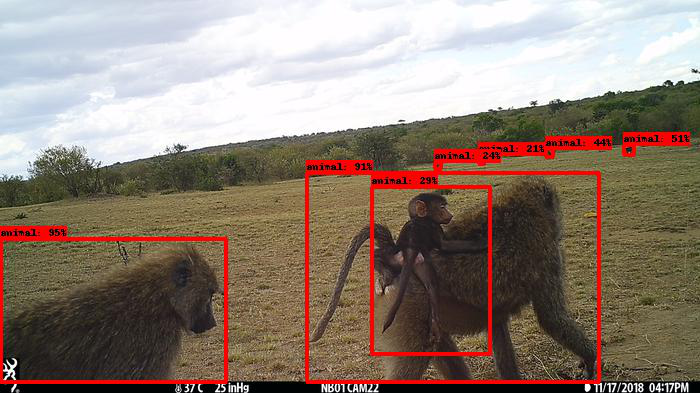

anno_2018_NB40_002921.JPG


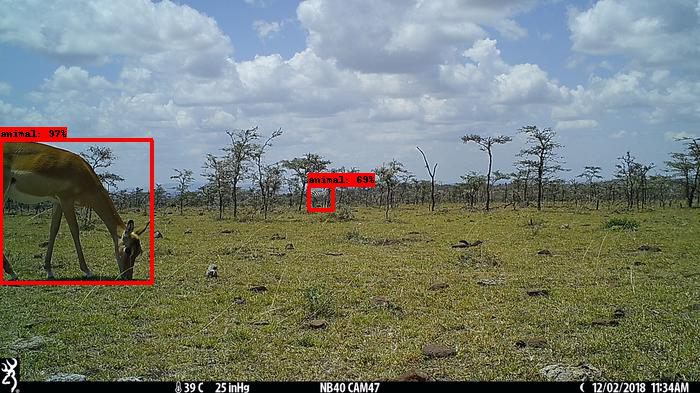

anno_2018_MT22_020230.JPG


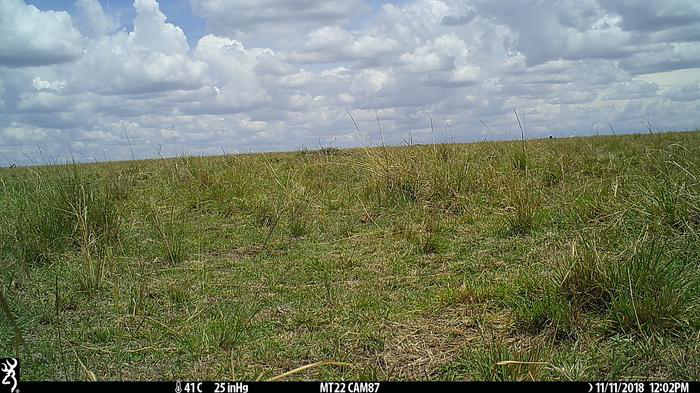

anno_2018_OMC11_009862.JPG


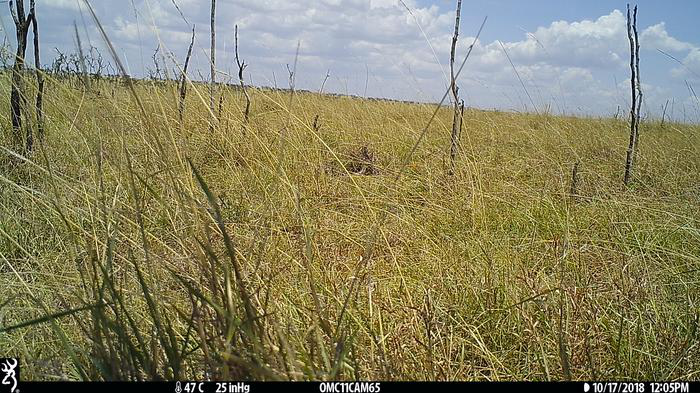

anno_2018_NB26_025049.JPG


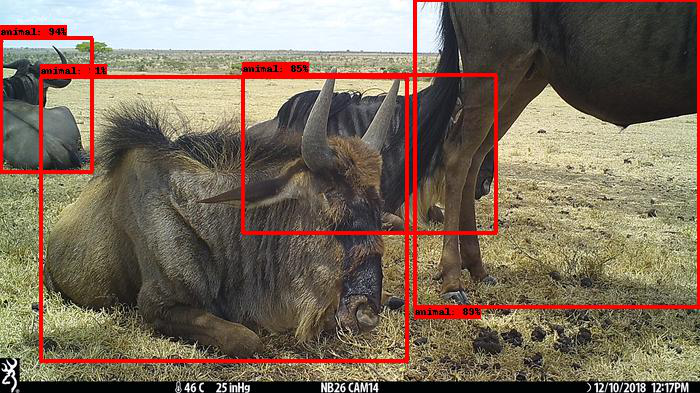

anno_2018_MN33_009632.JPG


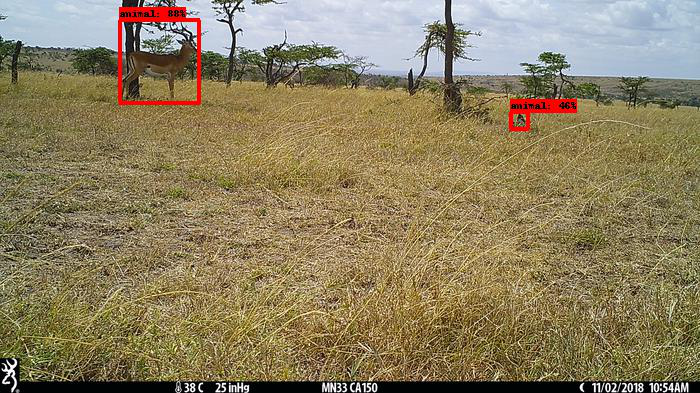

anno_2018_NB26_000679.JPG


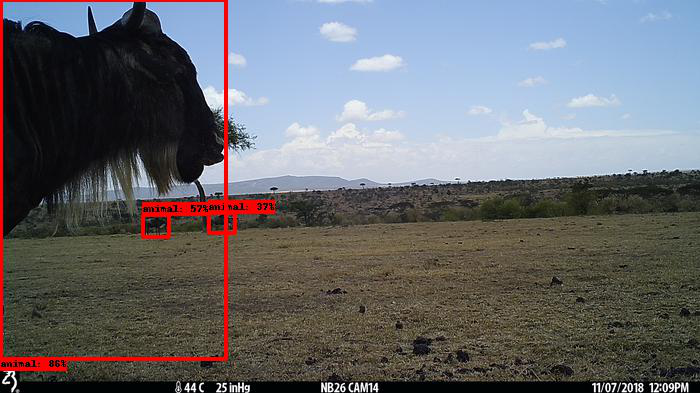

anno_2018_MT27_005639.JPG


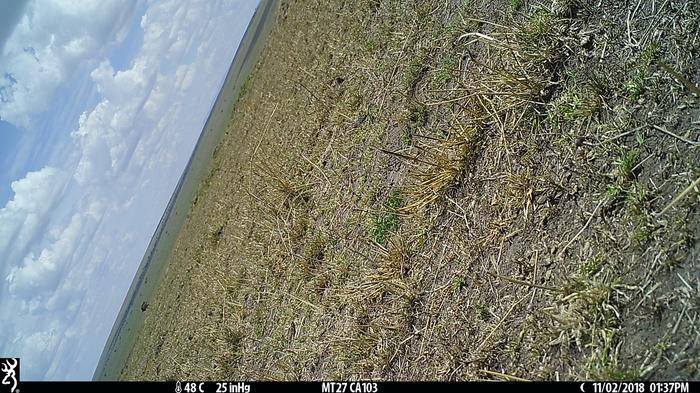

anno_2018_NB05_002216.JPG


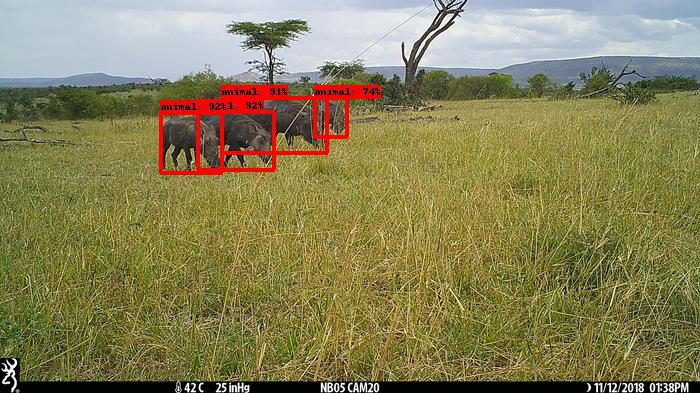

anno_2018_NB47_006890.JPG


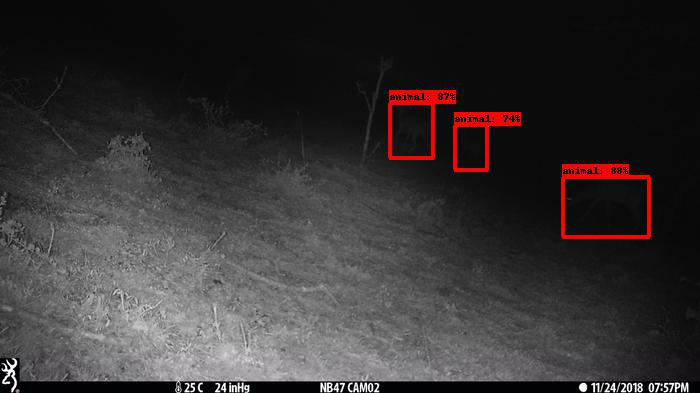

In [ ]:
# show the images with bounding boxes in Colab
for viz_file_name in ['anno_'+img for img in selected_list_of_images]: ## viewing tags from images seen before
  print(viz_file_name)
  im = Image.open(os.path.join(visualization_dir, viz_file_name))
  display(im)

**How many animals did you manage to find?!**

### Make detections analysis-ready

* We will now take a look into MegaDetector results across all of the 50 images stored under our image path.
* Below we save the results in a pandas dataframe format to make it easier to manipulate. Run the next cell without drawing focusing too much on the underlying code.

In [ ]:
## what do output categories of megadetector mean. we define 0 as the empty category, i.e. where there is no detection within an image with more than the treshold defined above
category_dict = {'0':'empty','1': 'animal', '2': 'person', '3': 'vehicle'}
## given detection output of megadetector, get the results in a pandas dataframe
md_df = transform_md_output_to_df(md_detections,category_dict)

### **Exercise** 🦌
---
<br>

Using the dataframe with the MegaDetector detections produced above (`md_df`), calculate:

* The percentage of empty images.
* The total number of animals detected with MegaDetector
* The maximum number of animals detected in a single image. Can you visualize this image?
* Number of animals per conservancy
* What are some obvious benefits of using megadetector?
* (Optional) If time allows change the confidence threshold of megadetector and see how the above conclusions change

Note: The rows in the dataframe are more than 50, why do you think that is the case?<br>

Pandas Tip: use the `.groupby()` function to make quick aggregate calculations


In [ ]:
# calculate  ...

To conclude, MegaDetector is a great general model that can be used to identify the camera trap images that include one or more animals and draw a box around them. The above can save a lot of human processing time given that a large percentage of the photos can be empty. However, MegaDetector does not identify animals to the species level, which is not enough for accurate biodiversity monitoring that depends on more detailed information for the data captured. 

For this reason, we can train a model to perform species classification given the boxes of animals. That is going to be the subject of the following task.

---

# **Part 2: Species Classification in the Wild**

* We are going to tackle the problem of Image Classification on a challenging real-world task. In particular, we will try to **recognize species in photos captured from camera traps** i.e. static cameras set up in the wild using Deep Learning 
* The dataset used here is a subset from the [**Caltech Camera Traps**](https://lila.science/datasets/caltech-camera-traps) collection (Beery et al., 2018) captured across 20 locations (CCT20)
* The training set consists of 6334 images distributed in an imbalanced manner across 15 species. Naturally, **some species appear during day, some during night** and some in both cases making their appearance more diverse.  
* The 15 categories are: badger, bird, bobcat, car, cat, coyote, deer, dog, fox, opossum, rabbit, raccoon, rodent, skunk, squirrel
* Moreover, the data come from **diverse locations** and for some of them there is **no overlap between the defined training and test sets**
* Finally, there is an extra difficulty associated with the fact that the images are collected in the wild. For example, we can have **blurry, noisy, occluded, partial, dark or distant views** of animals to recognize
<br>

In [ ]:
# path for classification data
classification_data_path = '/content/BIOS0032_AI4Environment_Lab3Data/classification_data/'
# get inside this path - run only once!
os.chdir(classification_data_path)

In [ ]:
# import libraries we'll use for the species classification task
import os
import json
import random
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import torchvision.models as models
## set a constant instead of random seed for repeatability
torch.manual_seed(42)

%matplotlib inline

# custom functions implemented
from dataset import CTDataset 
from training_utils import train,validate, accuracy,plot_confusion_matrix

In [ ]:
# if you have activated the GPU feature in the colab device you will get better performance, otherwise a (slower) CPU will be used
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

## Data Preparation
The images used in this task can be imagined as the boxes extracted by a tool such as MegaDetector accompanied with an expert-provided species label

### Load annotation and path file

* We load a python dictionary with rows that correspond to images of the CCT20 dataset 
* Each row mainly contains **path to the image**, the **target id** and the name of the **species** that relates with this target id and the **split** it belongs to. In addition it has information about the encoded **location** the photo was taken and the **datetime** which could be exploited for ecological analysis
* The dataset is already **split into train, validation and test**
* Notice the existence of the validation split here. This is typically used to select the best model or its hyperparameters during training as it remains independent to the training set <br>


In [ ]:
# available dataset versions
# cct20_labels.json: the default dataset.
# cct20_labels_large.json: more training images
# cct20_labels_random.json: like the default datset but the train, validation, test splits are selected in random

# dictionary with train,val and test data and every row in format [img_path, target_id, species]
with open('cct20_labels.json') as f:
    cct20_dict = json.load(f) 

In [ ]:
# let's see how data look like
random.sample(cct20_dict['train'],k=1)

[['train/58ce401b-23d2-11e8-a6a3-ec086b02610b_0_squirrel.jpg',
  2,
  'squirrel',
  108,
  '2011-09-17 15:20:32',
  'train',
  'Justin Brown']]

In [ ]:
# lets also store the metadata in a pandas dataframe for better accessibility for analysis
column_names = ['img_path','target_id','species','location','datetime','split','rights_holder']
cct20_df = pd.DataFrame()
# traverse dictionary entries and add rows to dataframe
for split in ['train','validation','test']:
  split_df = pd.DataFrame(cct20_dict[split],columns=column_names)
  cct20_df = pd.concat((cct20_df,split_df))
cct20_df = cct20_df.reset_index(drop=True)

In [ ]:
## number of classes
num_classes = cct20_df.target_id.nunique()
num_classes

15

Let's take a look into how each class can look like

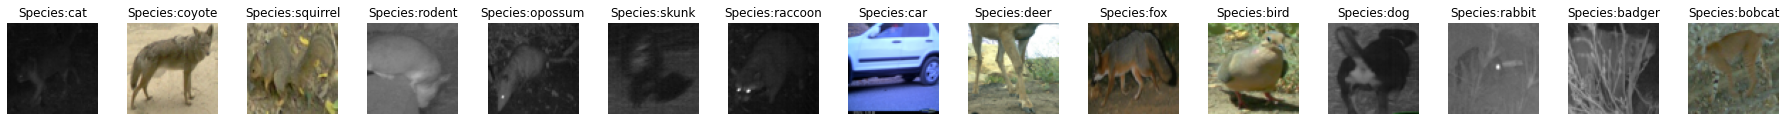

In [ ]:
fig = plt.figure(figsize=(25, 12))
i=1
for sp in set(cct20_df.species):
    sample_row = cct20_df.query('species==@sp').sample(1).iloc[0]
    fig.add_subplot(1,15,i)
    img = np.array(Image.open(sample_row.img_path).resize((64,64)) )
    plt.imshow(img)
    plt.axis('off')
    plt.title('Species:{}'.format(sample_row.species))
    i+=1
plt.tight_layout()
plt.show()

Also, notice that the test set has more locations than the training set. This means that the model will be evaluated in locations it has not been trained on

In [ ]:
cct20_df.groupby(['split']).location.nunique()

split
test          19
train         10
validation    11
Name: location, dtype: int64

Below we see how **imbalanced** are the classes of our dataset; some species are going to be better represented than others.

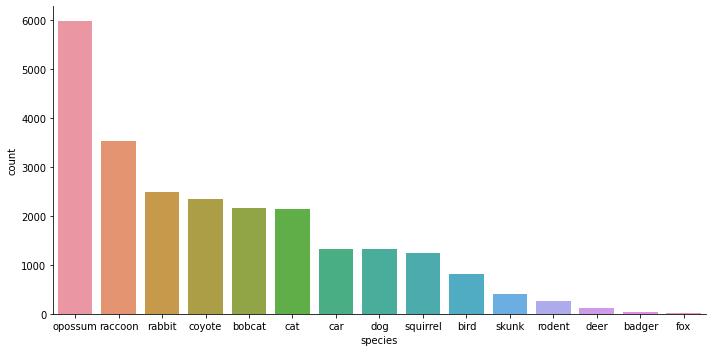

In [ ]:
import seaborn as sns
sns.catplot(kind='bar',x='species',y='count',
            data=cct20_df.species.value_counts().reset_index().rename(columns={'species':'count','index':'species'}),
            aspect=2)

### Image Augmentations
* During deep learning training, image augmentations can be used to provide a variety in the visual appearance of the input data given that the learning stage comprises of multiple epochs/steps. Below we select a set of such augmentations to "enhance" our training set

In [ ]:
# select final image resolution for image transformation.
img_res=32 

# image transformation to augment our dataset for better training. 
# the outcome of these transformation will be the input of the deep learning model
train_transform = T.Compose([
    T.Resize(size=img_res),
    T.RandomCrop(size=img_res),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)]),
    T.RandomGrayscale(),
    T.ToTensor(),
    ])

val_test_transform = T.Compose([
    T.Resize(size=img_res),
    T.CenterCrop(size=img_res),
    T.ToTensor(),
    ])

### Loading the camera trap dataset
* The following PyTorch utilities let you define how the training and test data are initialized and what is returned when we load data every iteration. 
Note: This functionality is implemented by us and you do not need to take any action
* The train, val and test splits are predefined.

In [ ]:
train_set = CTDataset(root_dir='',annotation_dict=cct20_dict['train'],transform=train_transform)
val_set = CTDataset(root_dir='',annotation_dict=cct20_dict['validation'],transform=val_test_transform)
test_set = CTDataset(root_dir='',annotation_dict=cct20_dict['test'],transform=val_test_transform)
batch_size =32
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

### Show how transformed images look like
* We preview what kind of transformations come out of the constructed dataloaders. 
* Below, we see differently augmented versions (some augmentations are stochastic) for each of the sample images:

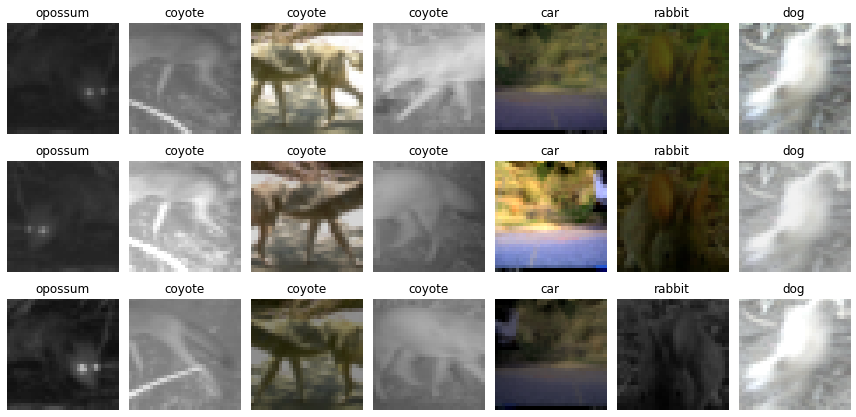

In [ ]:
# plotting 3 differently augmented versions of the same image. 
total_images = 7
total_iter = 3
np.random.seed(42)
random_image_idx =np.random.choice(list(range(0, len(train_set))),total_images)
train_set_subset = torch.utils.data.Subset(train_set, random_image_idx)

random_images = np.random.choice(range(0,batch_size),total_images)
fig,ax = plt.subplots(total_iter,total_images,figsize=(12,6))
for i in range(total_iter):
    train_loader_example = DataLoader(train_set_subset, batch_size=total_images, shuffle=False,drop_last=False)
    loaded_sample = next(iter(train_loader_example))
  
    for j in range(total_images):
        ax[i,j].imshow(np.array(loaded_sample['img'][j].permute([1,2,0]).cpu()))
        ax[i,j].axis('off')
        ax[i,j].axis('off')
        ax[i,j].set_title(loaded_sample['species'][j])
plt.tight_layout()

## Training

* The dataloaders defined above load the data for each batch either during the training or the prediction stage. The **train** and **validate** functions correspond to the actions taken during an iteration of the training or validation phase respectively. 
* The main difference is that **optimization takes place only during training** based on a defined loss function.

### Training Parameters
* Some **parameters** for the image classification training play an important role on the procedure.
* For example, **number of epochs** correspond to how many iterations we are going to operate through the dataset, the selected **model** is the type of neural network we are going to train, the **loss function** that orchestreates learning and the **optimization algorithm** thar defines how parameter updates take place
* Note: You can play with some of these later and observe how performance is affected

In [ ]:
# number of training epochs. Each epoch corresponds to a full iteration over our training images
num_epochs = 5

# loading a cnn model implemented in PyTorch. ResNet18 is picked arbitrarily here, we can select other architectures supported.
model = models.resnet18()
# loading a cnn model implemented in PyTorch PRETRAINED on ImageNet 
# model = models.resnet18(pretrained=True) #uncomment this line to try transfer learning i.e. using a pretrained network as our starting point

## input Features before final layer of the model
num_ftrs = model.fc.in_features

## we define the output size of the network as the number of classes, e.g. to produce a probability distribution over the 15 classes of CCT20
model.fc = torch.nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# we are using the cross entropy loss as our loss function
criterion = torch.nn.CrossEntropyLoss()
# and stochastic gradient descent (sgd) as the optimization algorithm
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### Training a model from Scratch
* We are going to use ResNet18, one of the CNN architectures already implemented in torchvision and train it from scratch on species recognition on Caltech Camera Traps (CCT20).
* If you wanna learn more about the network architectures follow the torchvision documentation or read the respective paper that suggested it. For example, information about the ResNet18 can be found [here](https://pytorch.org/vision/stable/models/resnet.html)

Training of our model... 
* We train the model for multiple iterations. Observe how training and validation accuracy evolve through training
* As the final model we keep the one that achieved the highest validation accuracy during training. <br>

In [ ]:
best_val_acc = 0
best_model_wts = copy.deepcopy(model.state_dict())
train_acc_list = []
val_acc_list = []
# main train loop
for epoch in range(0, num_epochs):
    print("Train epoch {} ... \n".format(epoch))
    # training step: train routine passes images through the model, get predictions and based on the available labels reward or punish these predictions and optimize network
    train_loss,train_acc = train(train_loader, model, criterion,optimizer, device)  
    # validation step: given the current model get predictions on the validation set of images
    val_loss, val_acc,_ = validate(val_loader,model,criterion,device,split='val')
    
    # store training and validation accuracies through training stage. these should be getting better as we train
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    
    # if new validation accuracy is the best so far, keep the model that produced it as the best version
    if val_acc>best_val_acc:
        print('New best validation accuracy on epoch {} \n \n'.format(epoch))
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        
print(f'Best validation Accuracy: {best_val_acc:4f} achieved on epoch {best_epoch}')

Train epoch 0 ... 

Train. Prec@1 42.126
Train. Loss 1.783

Val prec@1 44.618
Val loss 1.694

New best validation accuracy on epoch 0 
 

Train epoch 1 ... 

Train. Prec@1 55.039
Train. Loss 1.375

Val prec@1 48.982
Val loss 1.542

New best validation accuracy on epoch 1 
 

Train epoch 2 ... 

Train. Prec@1 61.734
Train. Loss 1.169

Val prec@1 53.885
Val loss 1.383

New best validation accuracy on epoch 2 
 

Train epoch 3 ... 

Train. Prec@1 64.968
Train. Loss 1.058

Val prec@1 54.939
Val loss 1.351

New best validation accuracy on epoch 3 
 

Train epoch 4 ... 

Train. Prec@1 68.551
Train. Loss 0.968

Val prec@1 61.027
Val loss 1.259

New best validation accuracy on epoch 4 
 

Best validation Accuracy: 61.027299 achieved on epoch 4


## Evaluation

### Training Accuracy vs Validation Accuracy
* We plot the progress of the training and the validation accuracy given predictions by the model during its training stages. Are we overfitting? 
* This plot reveals the progress during training. As you can see the model kept learning after the first 5 epochs so it is highly likely that we would get better results if we let it train for more time

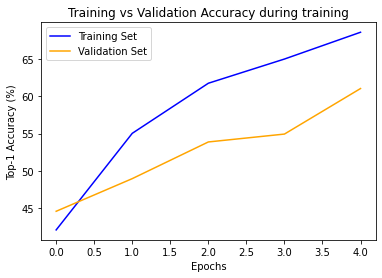

In [ ]:
plt.title('Training vs Validation Accuracy during training')
plt.plot(train_acc_list,color='blue',  label = 'Training Set')
plt.plot(val_acc_list,color='orange',  label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Top-1 Accuracy (%)')
plt.legend()
plt.show()

### Test set Evaluation
* Now we apply the trained model on the unseen test set and get its predictions and the accuracy. 

In [ ]:
# load best model weights
model.load_state_dict(best_model_wts)
# evaluate on unseen test set
_, test_acc,preds = validate(test_loader,model,criterion,device,split='test')

### Make predictions analysis ready
Get predictions across images in a dataframe

In [ ]:
# add test image predictions in a dataframe
cct20_pred_df = cct20_df.query('split=="test"').copy()
cct20_pred_df['predicted_target_id'] = np.array(preds)
# create a dictionary that maps target_id / predicted_target_id to species
target_id_to_species = dict(cct20_pred_df.drop_duplicates('target_id')[['target_id','species']].sort_values('target_id').values)
cct20_pred_df['predicted_species'] = cct20_pred_df['predicted_target_id'].apply(lambda x: target_id_to_species[x])

### **Exercise** 🦓
---
<br>

Using the dataframe with the model predictions (`cct20_pred_df`) do the following:
* Calculate and ideally plot the test **accuracy per species**. Above we have calculated overall accuracy but breaking down will inform us where our model struggles the most.
* Calculate the accuracy of the model across test **locations** comparing performance between **seen** and **unseen** locations. Unseen locations, essentialy correspond to camera trap sites producing images that are not included during training. Below we provide the two sets of locations

In [ ]:
# calculate  ...

In [ ]:
unseen_locations = set(cct20_df.query('split=="test"').location) - set(cct20_df.query('split=="train"').location)
seen_locations = set(cct20_df.query('split=="test"').location).intersection(set(cct20_df.query('split=="train"').location))

### Species Confusion Matrix
* As we mentioned before, accuracy might not always be the right metric
* A confusion matrix also reveal the types of mispredictions that take place and is a useful way to perform error analysis and imrove our model in an informed way
* A healthy confusion matrix has a green (high accuracy) diagonal and red (low accuracy) elsewhere

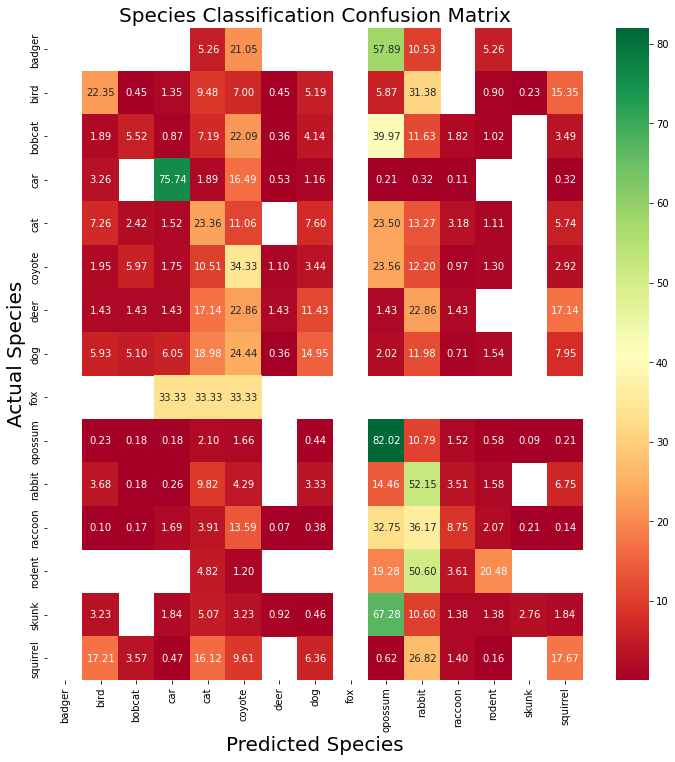

In [ ]:
plot_confusion_matrix(cct20_pred_df)


## Exercise: Transfer Learning 🦆
* Now let's use the same architecture used above (i.e. ResNet18) but **start from a pretrained version** (ImageNet weights) instead of training from scratch.
* Transfer-learning from models pretrained on larger datasets is quite common practice in computer vision, i.e. models can be pretrained on ImageNet which instead totals around 1 million images that cover 1000 different classes.

All you need to do go above in *Training Parameters* and replace `models.resnet18()` with ` models.resnet18(pretrained=True)`

**If time allows**, you can proceed with the following exercises to get more insights about decisions in the training process

## Exercise: Using more training data 🦍


Now let's use a larger portion of data in our training set.
* Go to the *Load annotation and path file* section and replace *cct20_labels.json* with *cct20_labels_large.json*
* Re-run the above chunk of code. You can run either training from random initialization OR transfer learning for simplicity
* What are your findings on the results after increasing the training data?


## Exercise: Split train, validation and test sets differently 🦒

* Similarly to above, we replace dataset with an alternative version. Here we use the same images as in *cct20_labels.json* but the train/validation/test splits are selected randomly. 
* Go to the *Load annotation and path file* section and replace *cct20_labels.json* with *cct20_labels_random.json*
* Re-run the above chunk of code. You can run either training from random initialization OR transfer learning for simplicity
* What are your findings on the results after training with random? What's the relationship between the training and the validation/test loss now?

## Additional Tasks (Optional)
* You can **run for more epochs** to actually reach a point where the model converges. It just takes a lot of time for this lab session
* Experiment **by changing the utilized loss function or the gradient optimizer and** its parameters such as the learning rate. 
* **Increase image size** from 32 by 32. Actually given image size was quite small. Classes with fine-grained differences might suffer from low resolution. A resolution around 128 would make more sense but hard to process without a GPU.
* **Use larger model**. Likewise, it's fair to assume that using a better backbone, e.g. by replacing the pre-implemented ResNet18 with a ResNet50 which has double the size of parameters will lead to better performance. Again, to use a larger backbone model you'll probably need a large machine



---


You are encouraged to explore the rich documentation of PyTorch and learn more about this deep learning library
You may find practical info for tools such as the ones used on this lab under the [PyTorch](https://pytorch.org/docs/stable/index.html) or [Torchvision](https://pytorch.org/vision/stable/) documentations. Also, here is a nice computer vision tutorial if you want to dig more into computer vision with PyTorch
[Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)